In [33]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
import pycountry
from nltk.corpus import stopwords
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [71]:
# umap_model = umap.UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False)

def bertopic_model(text):
    topic_model = BERTopic(
        top_n_words = 10,
        # embedding_model = None,
        min_topic_size = 5,
        nr_topics = 'auto',
        )
    topics, probs = topic_model.fit_transform(text)
    return topic_model, topics

In [72]:
data = pd.read_csv('/root/code/renzorico/speeches-at-UN/raw_data/short_preprocessed_text.csv')
data.head()

,Unnamed: 0,iso,year,speeches,country_dup,Name of Person Speaking,Post,order,country,cleaned,preprocessed,entities
0,0,BEL,1950,Never before have men throughout the world mor...,Belgium,Mr. VAN ZEELAND,NaN,10375.0,Belgium,never before have men throughout the world mor...,man world fervently unanimously wish peace . s...,"['115', 'week', 'week', 'the past three or fou..."
1,1,BLR,1950,It is now five years since the United Nations ...,Byelorussian Soviet Socialist Republic,Mr. KISELEV,NaN,10397.0,Belarus,it is now five years since the united nations ...,"year United Nations Charter , lay fundamental ...","['five years', 'the United Nations Charter', '..."
2,2,FRA,1950,"At the conclusion of this general discussion, ...",France,Mr. R. SCHUMAN,NaN,10391.0,France,at the conclusion of this general discussion i...,"conclusion general discussion , eloquence expe...","['five', 'Assembly', 'first', 'the United Nati..."
3,3,PAK,1950,May I be permitted to congratulate the General...,Pakistan,Sir Mohammad ZAFRULLA KHAN,NaN,10386.0,Pakistan,may i be permitted to congratulate the general...,permit congratulate General Assembly choice Pr...,"['the General Assembly', 'fifth', 'Assembly', ..."
4,4,TUR,1950,The era inaugurated by the creation of the Uni...,Turkey,Mr. SARPER,NaN,10382.0,Turkey,the era inaugurated by the creation of the uni...,era inaugurate creation United Nations critica...,"['the United Nations', 'Organization', 'the Un..."


In [74]:
model, topics = bertopic_model(data['preprocessed'])

In [75]:
#Getting most frequent words by document

countries = list(pycountry.countries)
country_names = [country.name.lower() for country in countries]

stop_words = set(stopwords.words('english'))
stop_words.add('country')
stop_words.update(country_names)
stop_words = list(stop_words)

vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=2000, stop_words=stop_words)

X = vectorizer.fit_transform(data['cleaned'])
X_array = X.toarray()

df = pd.DataFrame(X_array, columns =vectorizer.get_feature_names_out() )

word_scores = np.argmax(X_array, axis= 1)
unique, counts = np.unique(word_scores, return_counts=True)
word_count_df = dict(zip(unique, counts))
word_count_df = pd.DataFrame({'word': word_count_df.keys(), 'counts': word_count_df.values()})

features_list = vectorizer.get_feature_names_out()
word_count_df['feature'] = word_count_df['word'].apply(lambda x: features_list[x])
word_count_df = word_count_df.drop('word', axis=1)

stop_list = ['united nations','united states', 'international community', 'human rights', 'security council', 'general assembly', 'middle east',
               'international law', 'international community', 'international criminal',
               'international criminal court', 'international peace', 'international security', 'international tribunal', 'international cooperation', 'south africa',
               'european union', 'african union', 'united kingdom', 'united nations security', 'united nations general', 'united nations general assembly', 'soviet union',
               'latin america', 'north america', 'south america', 'viet nam','central america', 'east asia', 'south asia', 'south east asia', 'eastern europe', 'western europe',
               'el salvador', 'indian ocean', 'pacific ocean', 'atlantic ocean', 'arab league', 'european','siere leone', 'sierra leone', 'sierra leonean', 'sierra leoneans',
               'costa rica', 'per cent', 'mr president', 'small island', 'democratic republic', 'people republic',
               'republic congo', 'republic iran', 'republic korea', 'european community', 'cent']

stop_list.extend(country_names)
word_count_df = word_count_df.loc[~word_count_df['feature'].isin(stop_list)]
top_1000 = word_count_df.sort_values(by='counts', ascending=False).head(1000)


In [76]:
top_1000.to_csv('/root/code/renzorico/speeches-at-UN/raw_data/top_1000_words.csv')

In [77]:
custom_stopwords = ['united nations','united states', 'international community', 'human rights', 'security council', 'general assembly', 'middle east',
               'international law', 'international community', 'international criminal',
               'international criminal court', 'international peace', 'international security', 'international tribunal', 'international cooperation', 'south africa',
               'european union', 'african union', 'united kingdom', 'united nations security', 'united nations general', 'united nations general assembly', 'soviet union',
               'latin america', 'north america', 'south america', 'viet nam','central america', 'east asia', 'south asia', 'south east asia', 'eastern europe', 'western europe',
               'el salvador', 'indian ocean', 'pacific ocean', 'atlantic ocean', 'arab league', 'european','siere leone', 'sierra leone', 'sierra leonean', 'sierra leoneans',
               'costa rica', 'per cent', 'mr president', 'small island', 'democratic republic', 'people republic',
               'republic congo', 'republic iran', 'republic korea', 'european community', "united", "nations", "people", "shall", "president", 'delegation',
               'world', 'herzegovina']

In [78]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=(1, 3), min_df=5, max_features=1_000)
model.update_topics(data['preprocessed'], vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model)

In [79]:
model.visualize_topics()

In [80]:
model.visualize_hierarchy(top_n_topics=50)

In [81]:
topic_words = model.get_topic_freq().apply(lambda row: model.get_topic(row[0]), axis=1)
df_topics = pd.DataFrame({'Topic': topic_words.index, 'Words': topic_words.values})
df_topics

,Topic,Words
0,2,"[(new, 0.1357356672314795), (economic, 0.13502..."
1,3,"[(delegation, 0.17600401904121435), (disarmame..."
2,7,"[(american, 0.22919289302920987), (latin, 0.21..."
3,35,"[(fiftieth, 0.22573473255713294), (anniversary..."
4,9,"[(sustainable, 0.26706321140006967), (sustaina..."
5,24,"[(rhodesia, 0.20418824297929583), (africa, 0.1..."
6,36,"[(crisis, 0.27479908020868715), (climate chang..."
7,5,"[(viet, 0.22419448384251905), (united states, ..."
8,1,"[(soviet union, 0.2594319687748087), (soviet, ..."
9,4,"[(korea, 0.3855669015451923), (korean, 0.33778..."


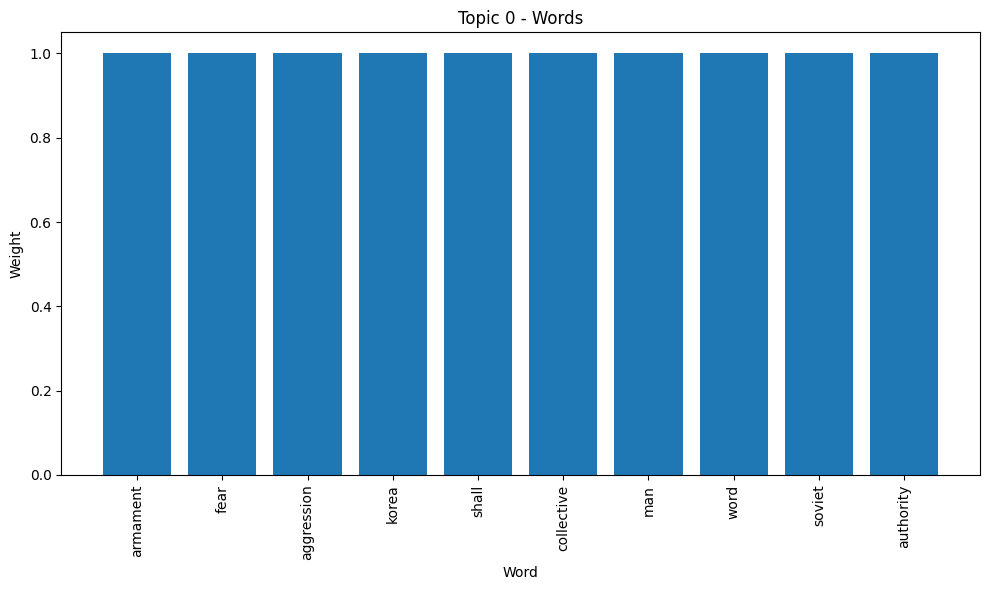

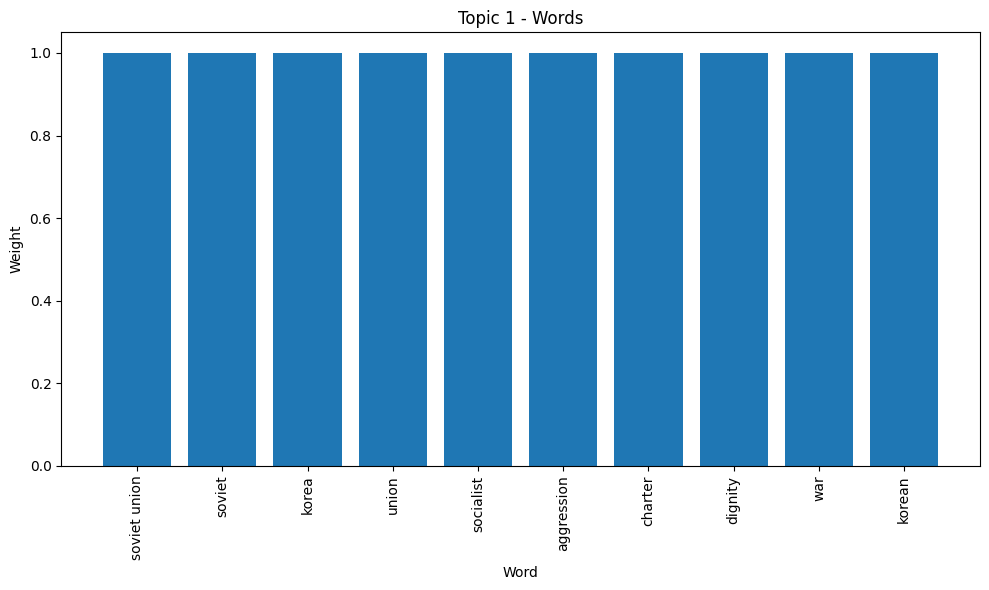

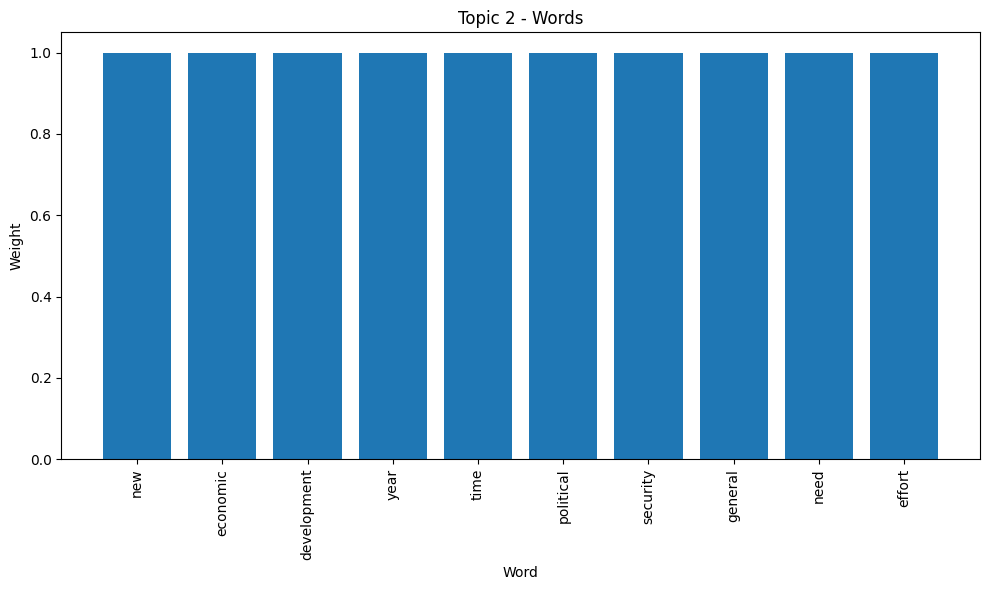

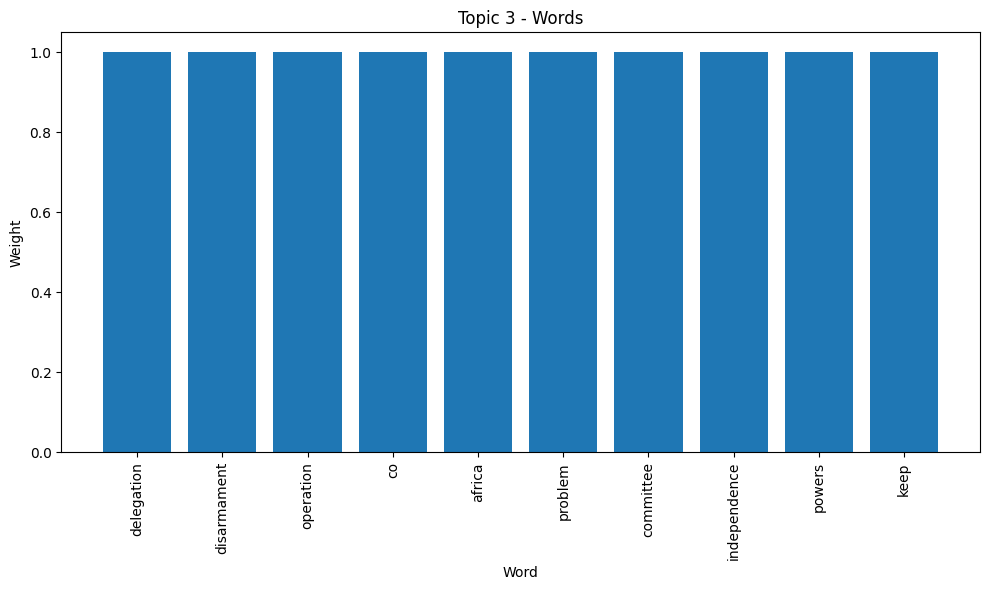

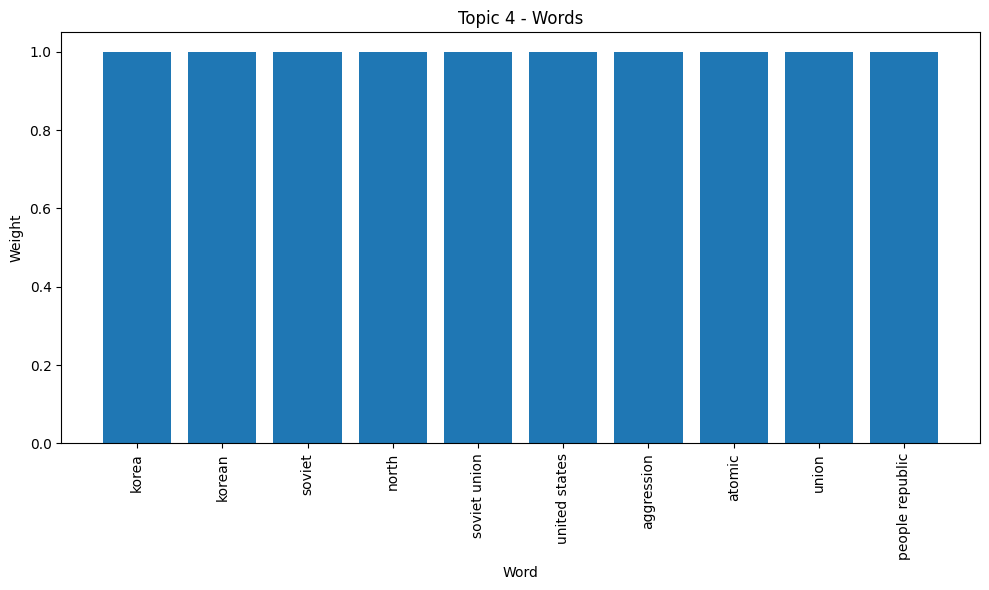

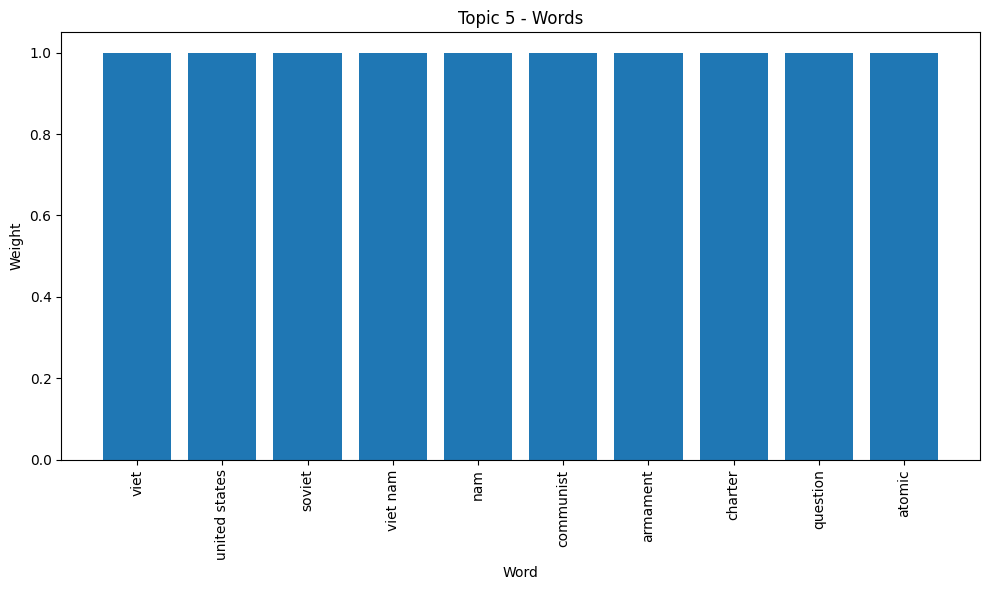

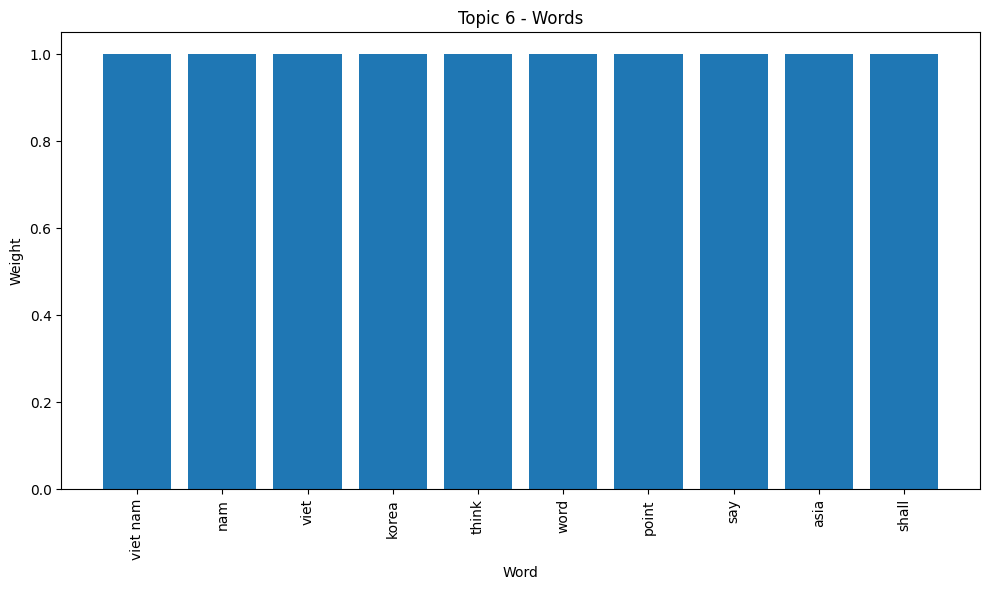

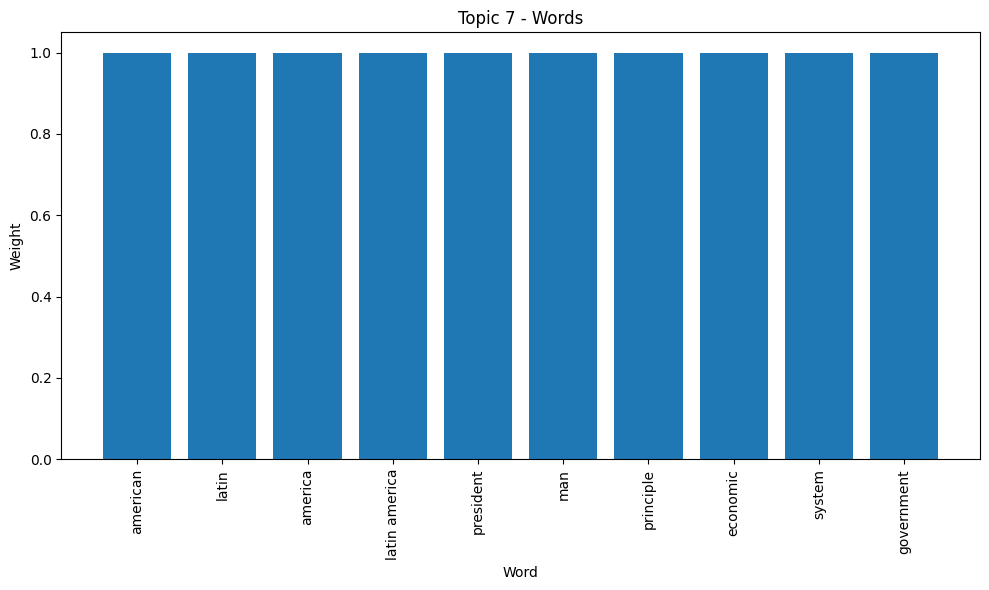

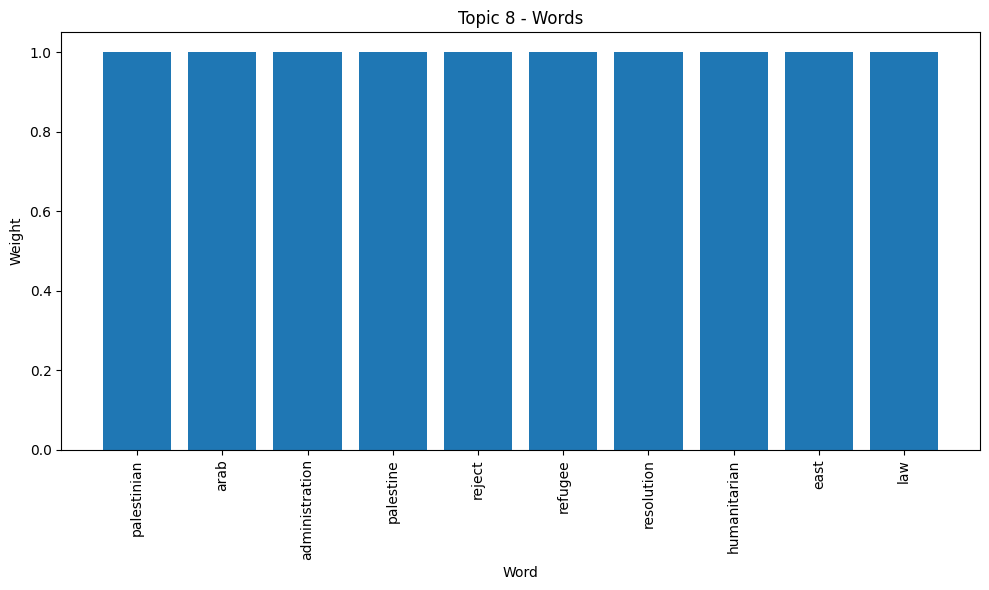

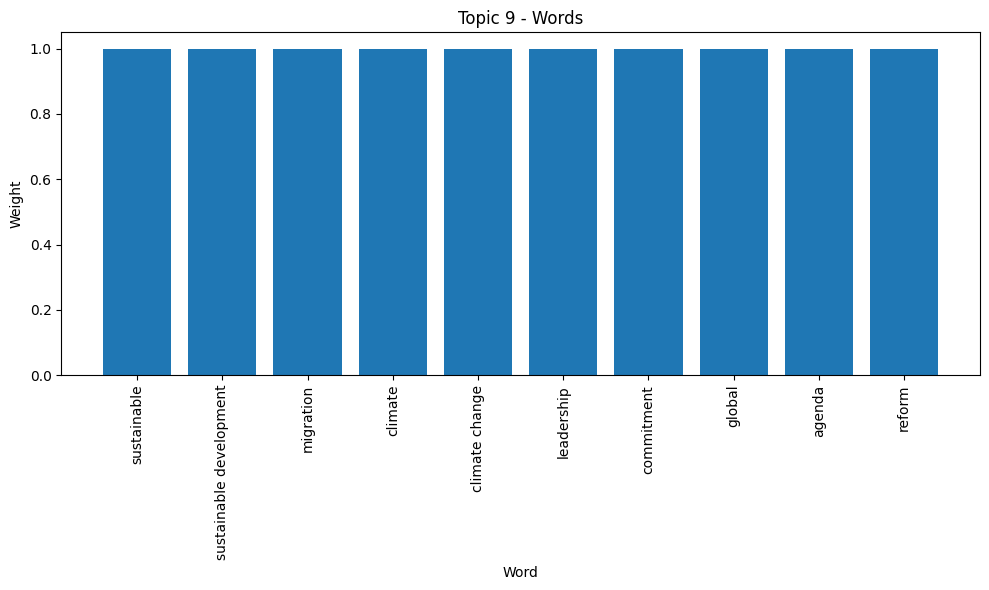

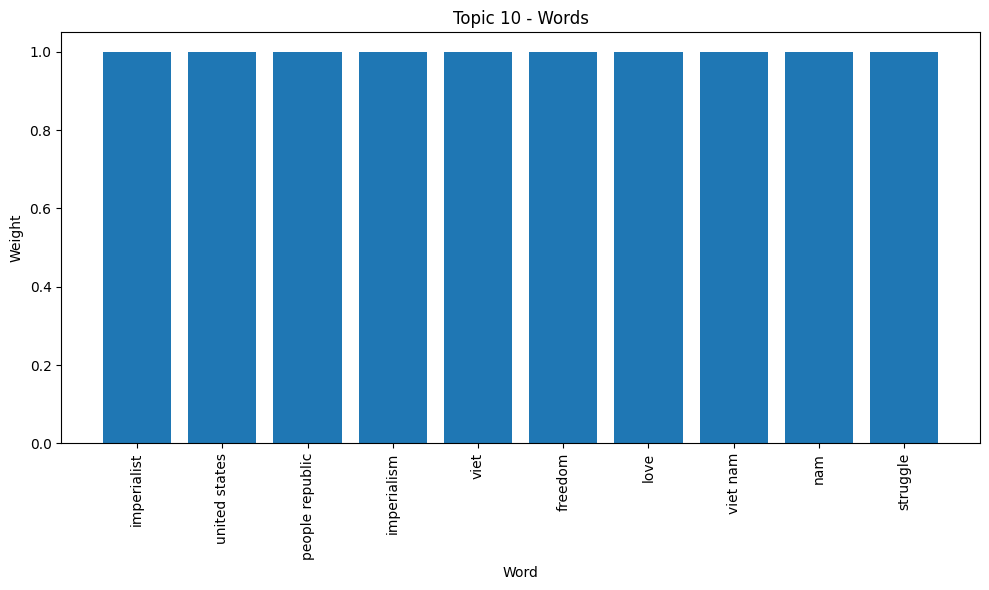

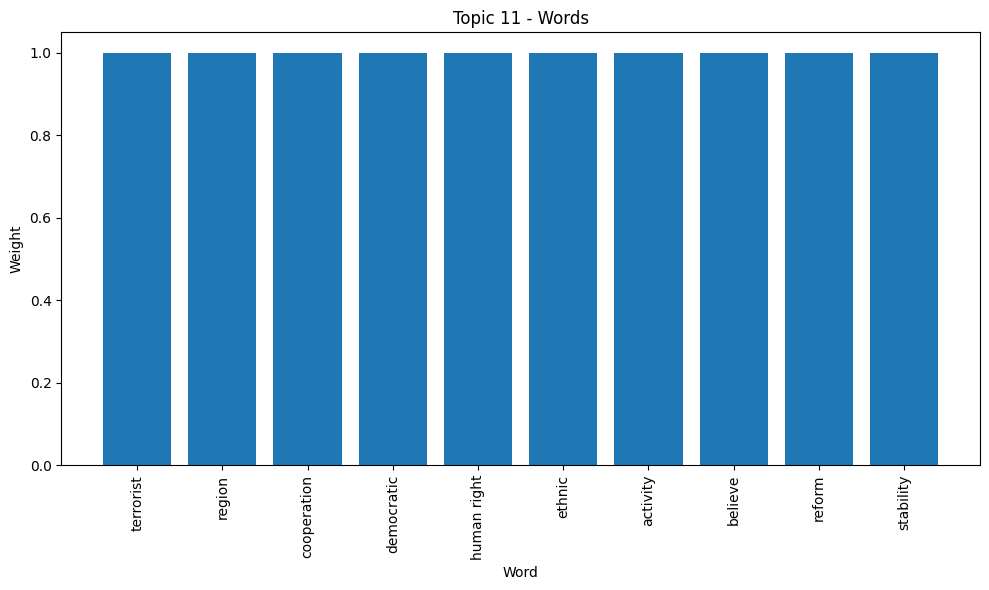

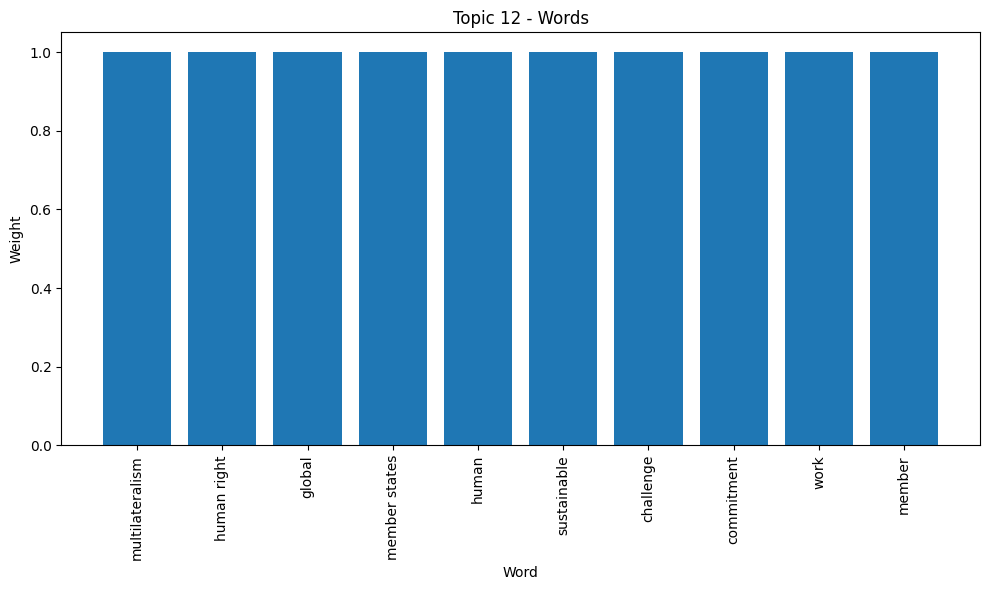

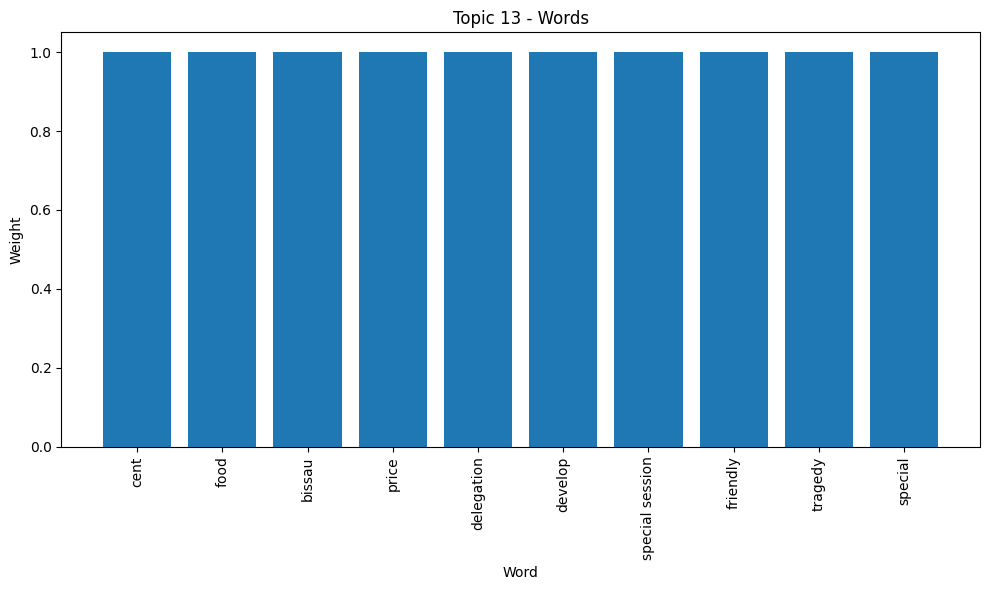

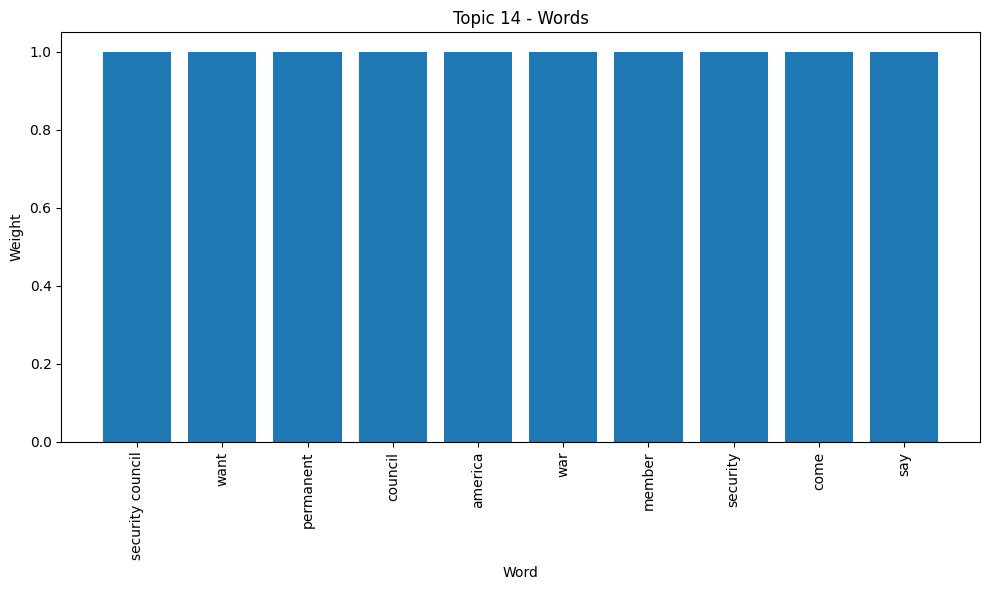

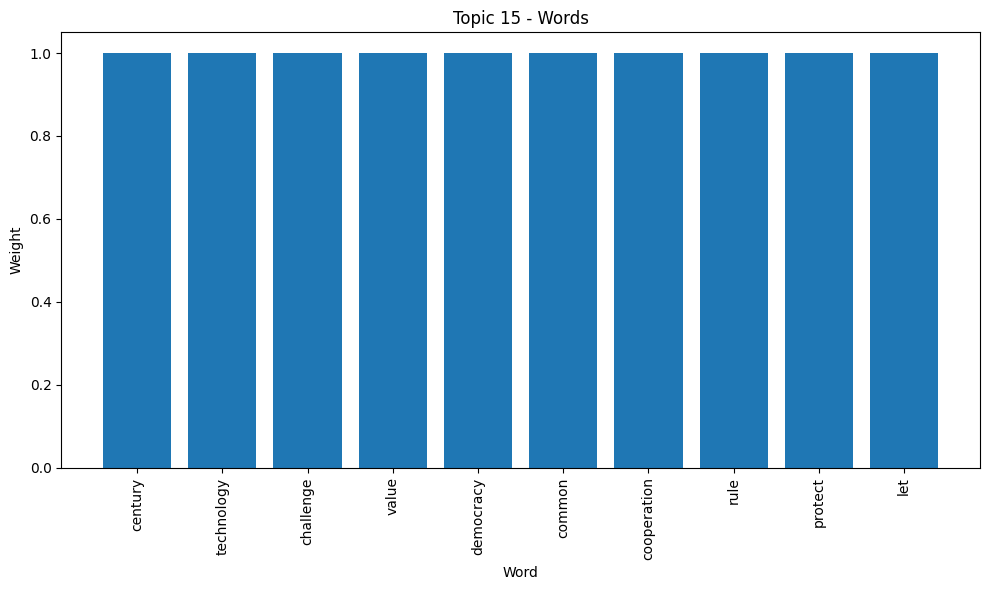

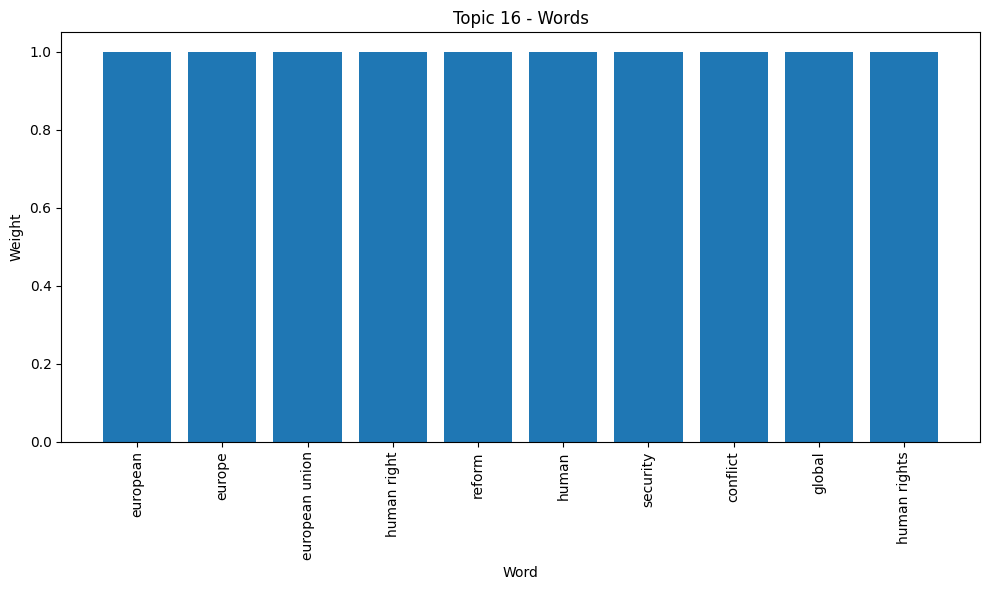

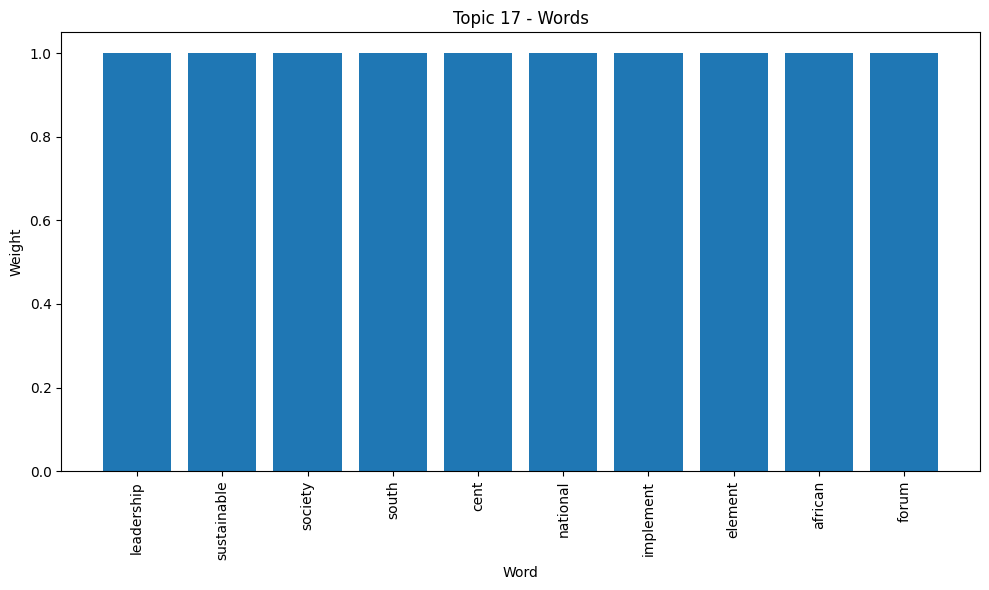

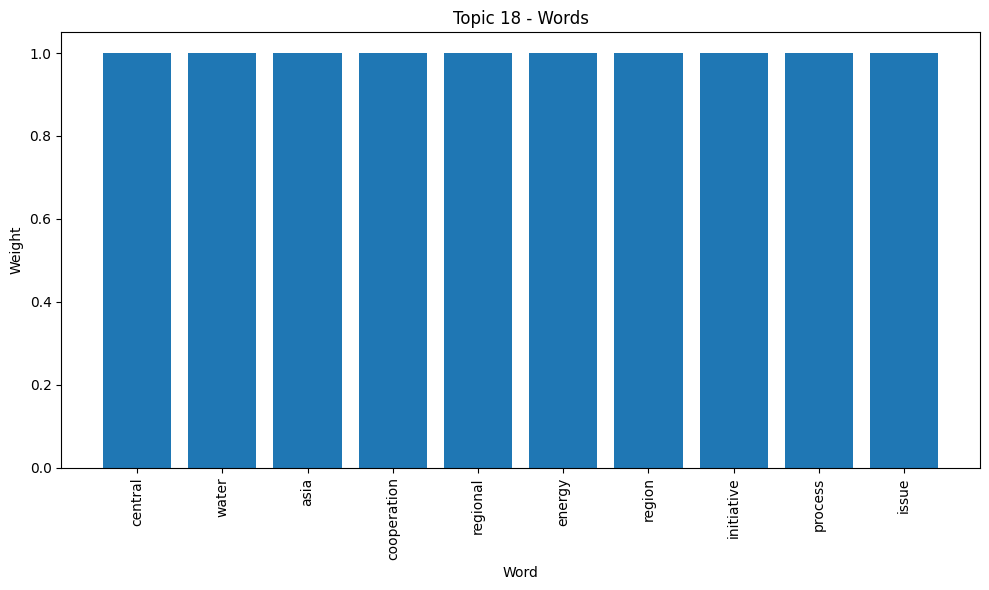

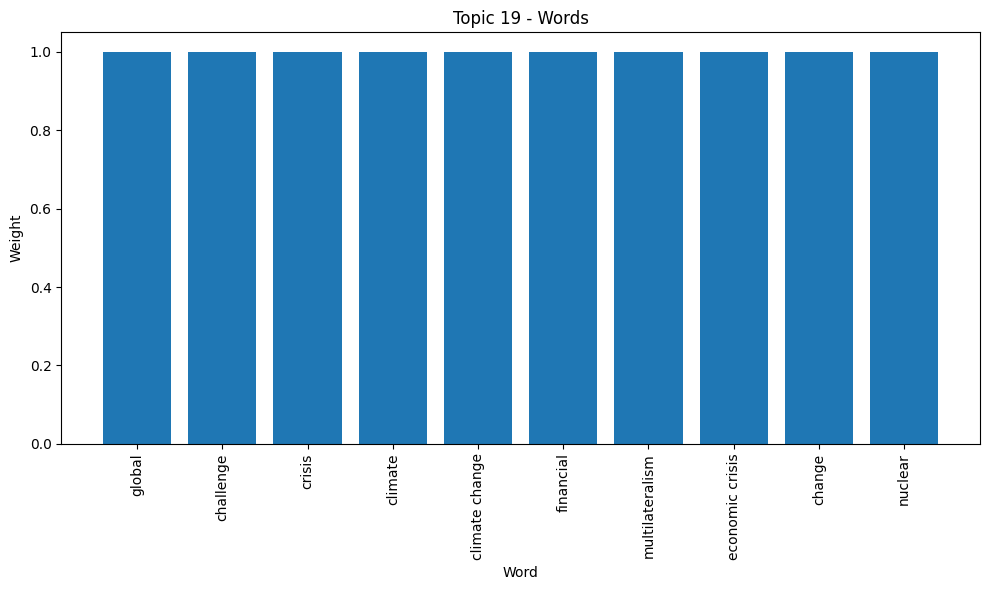

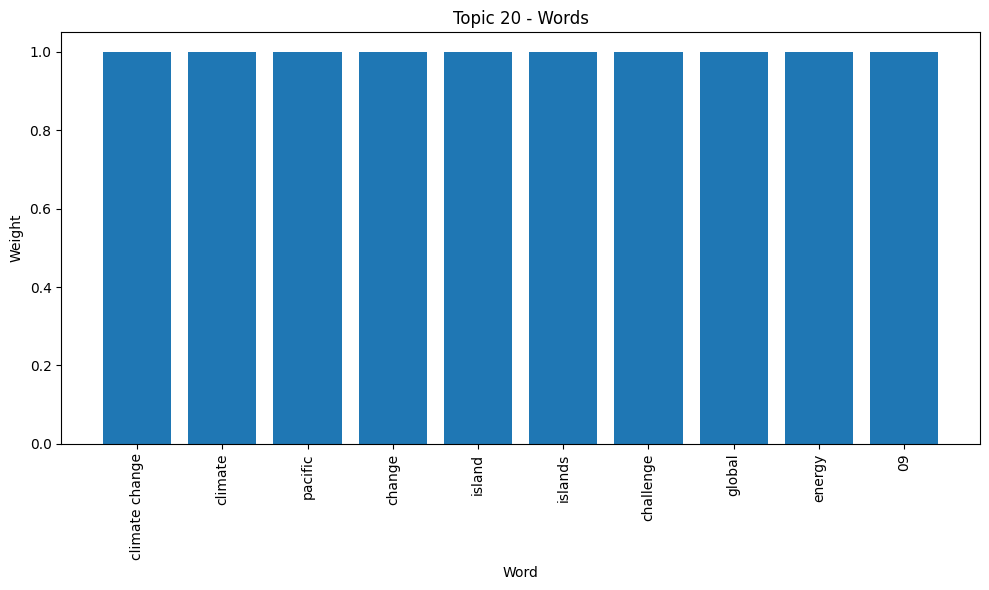

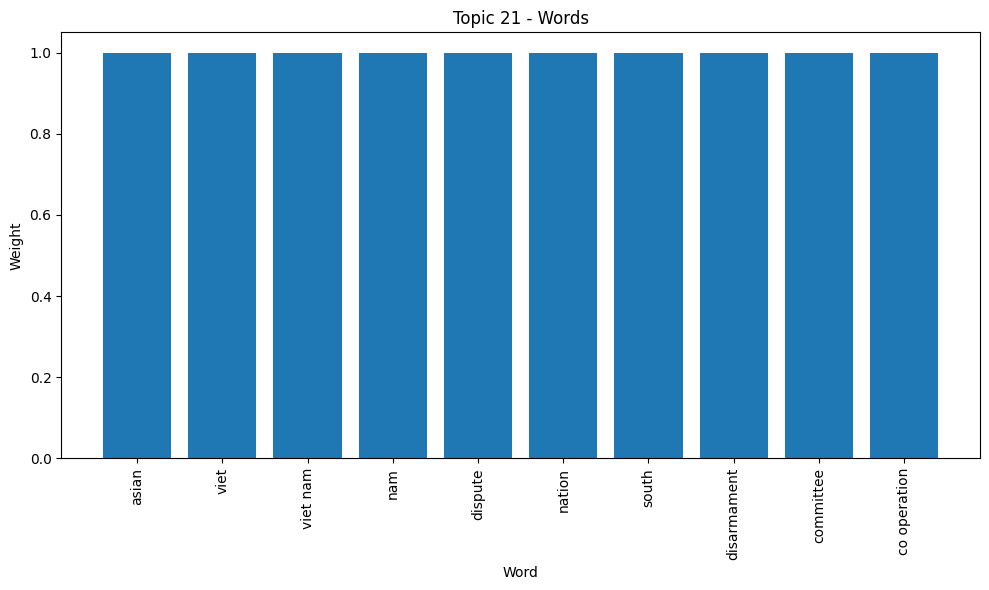

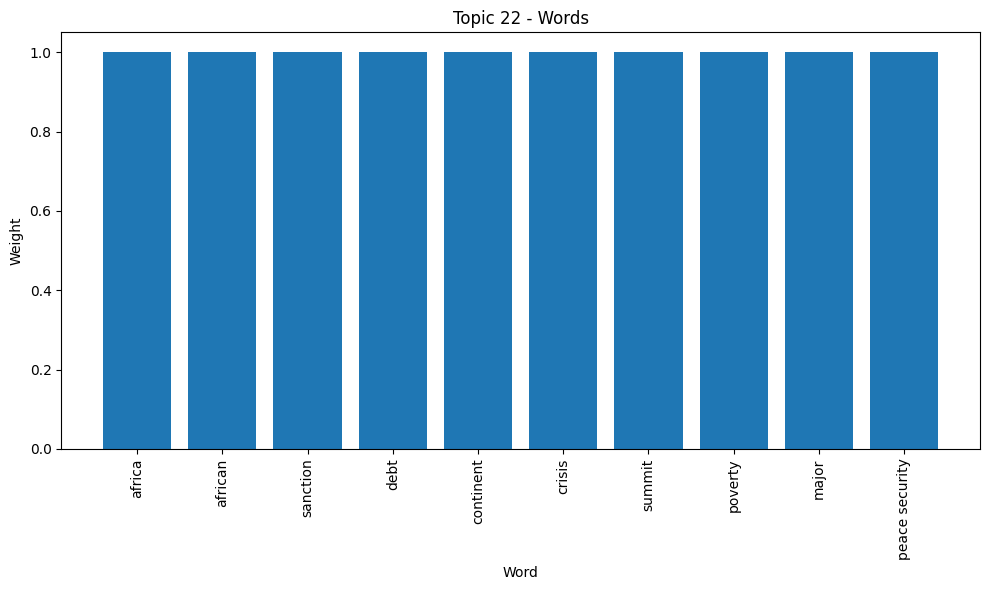

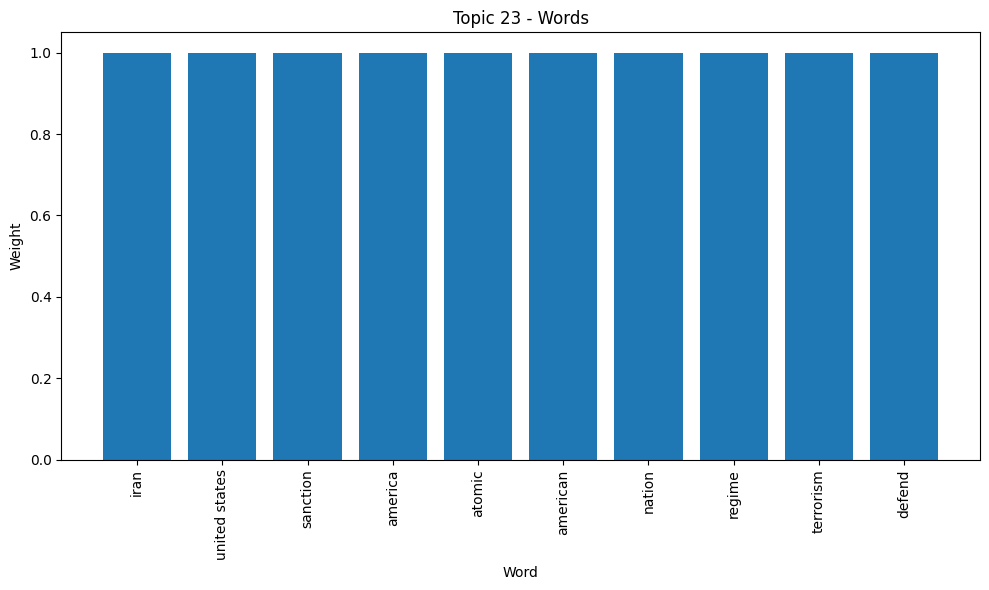

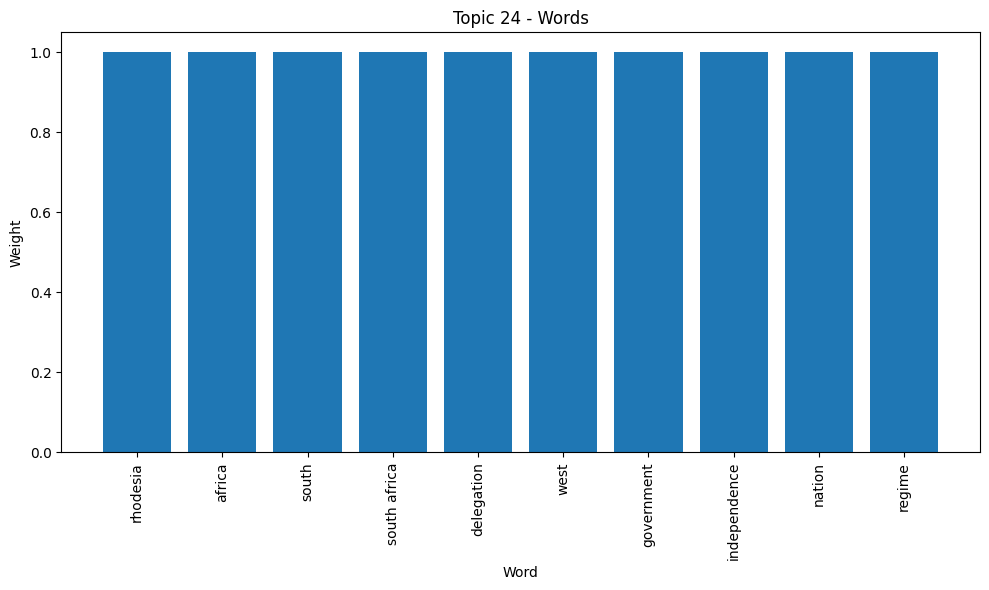

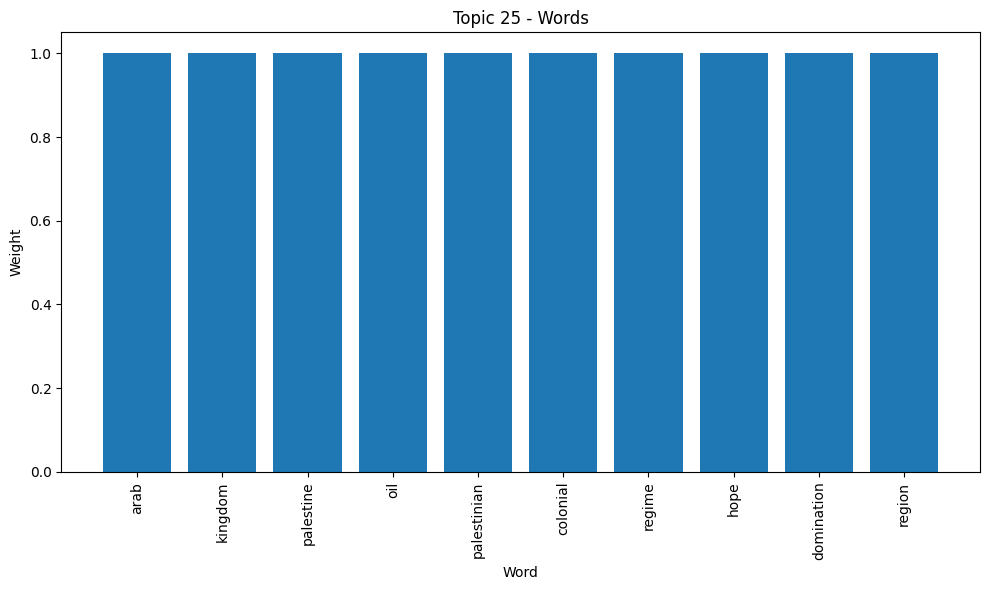

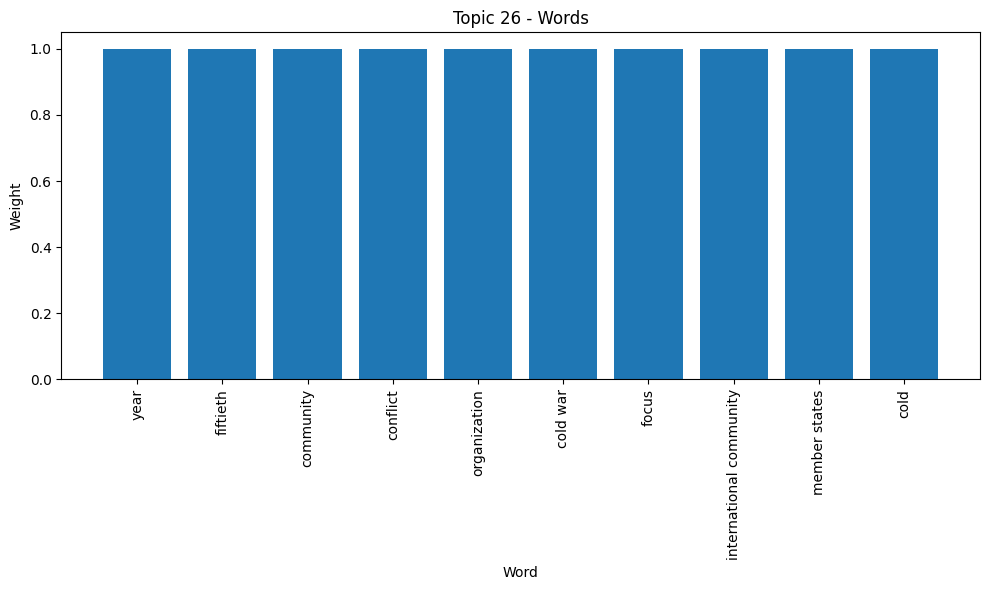

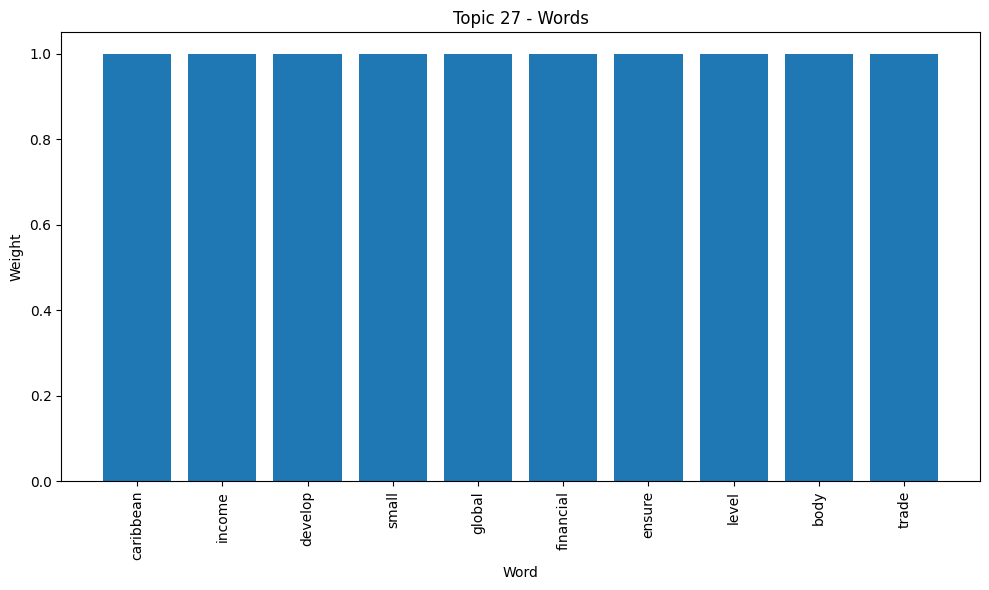

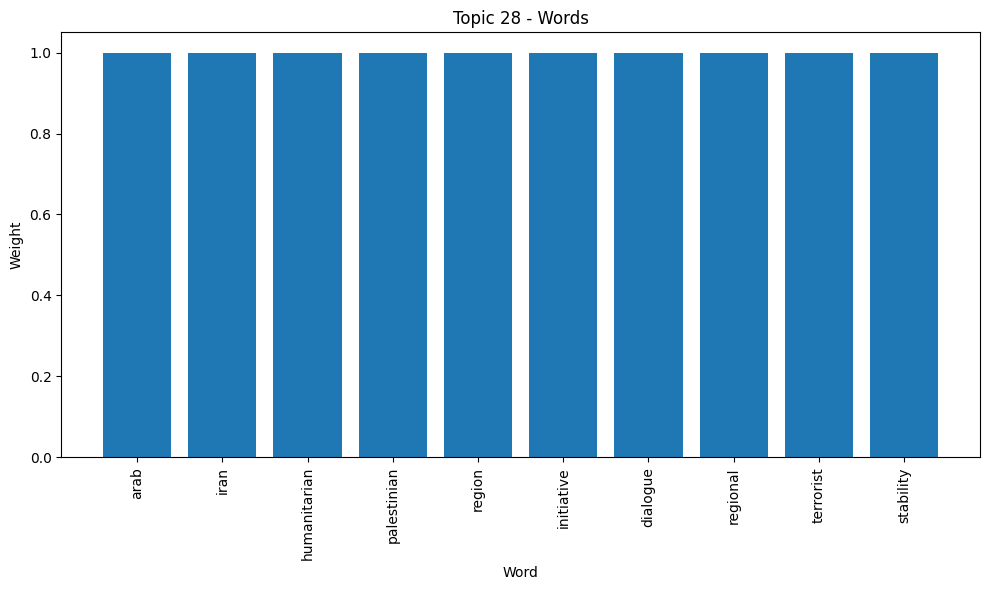

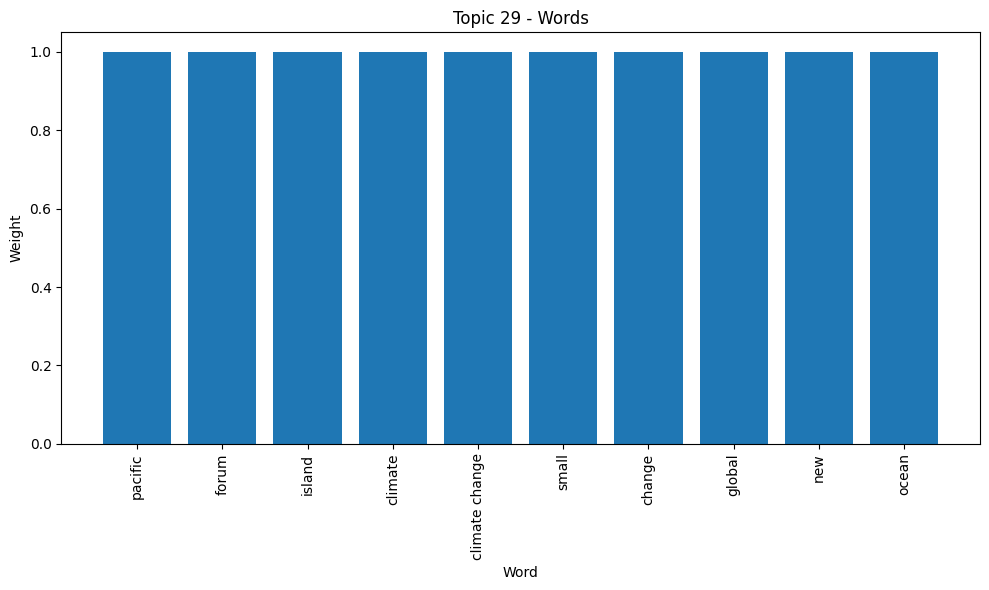

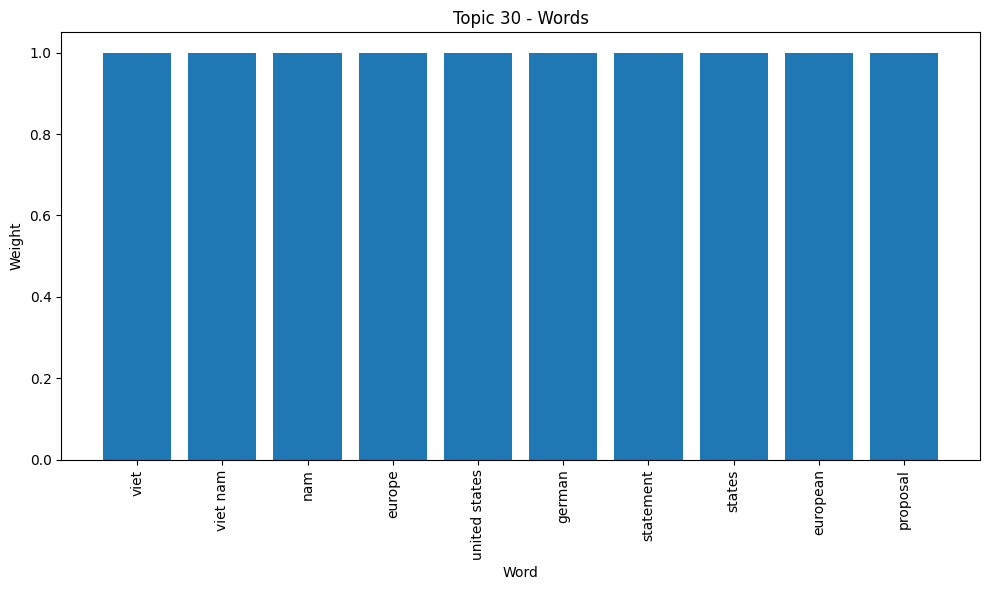

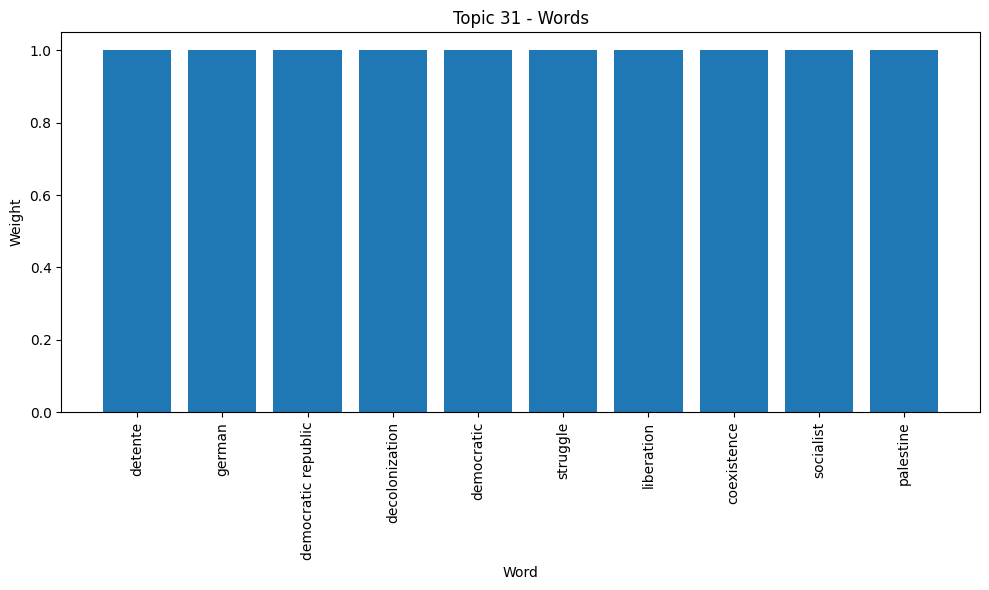

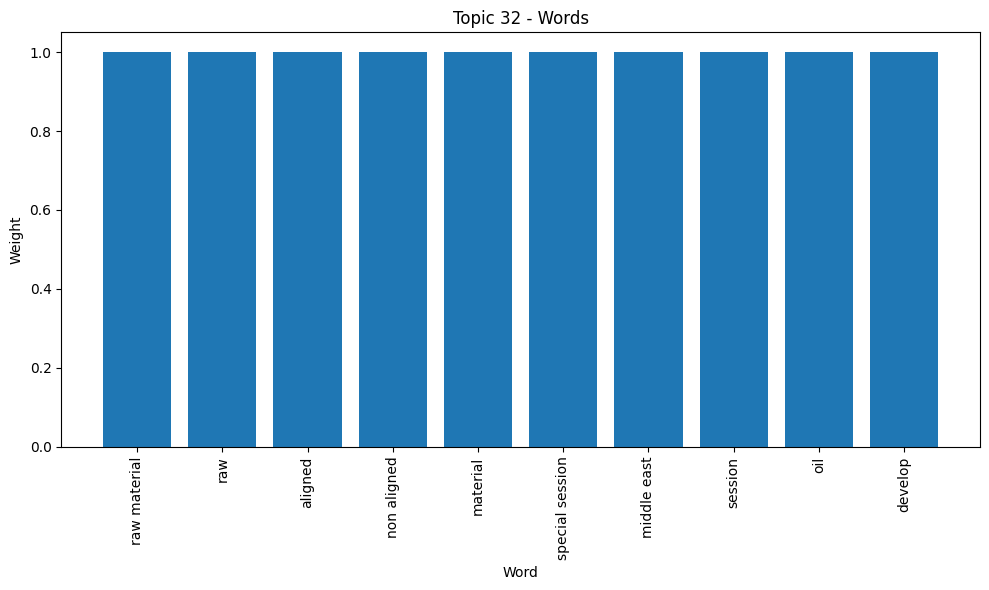

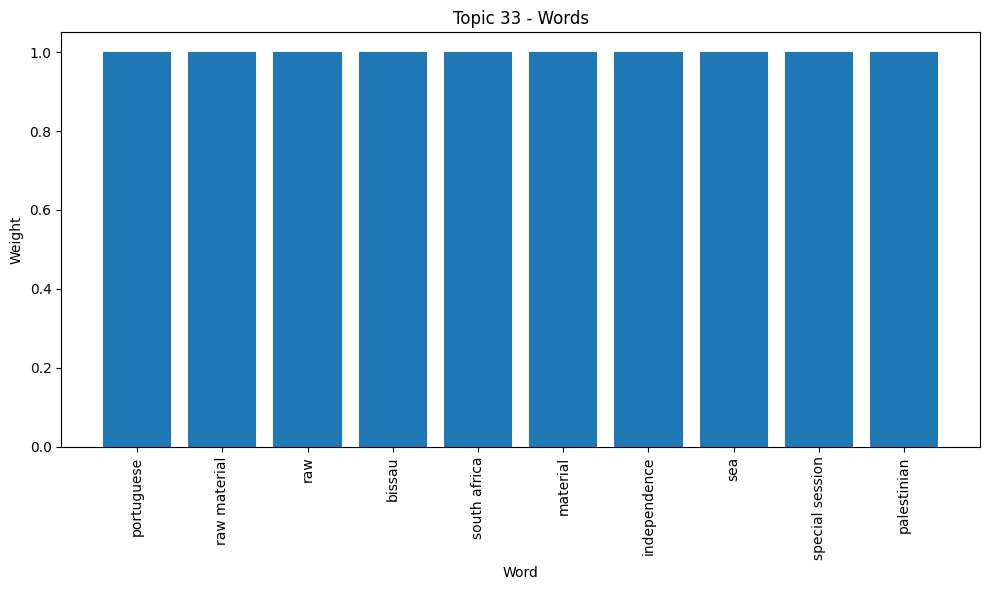

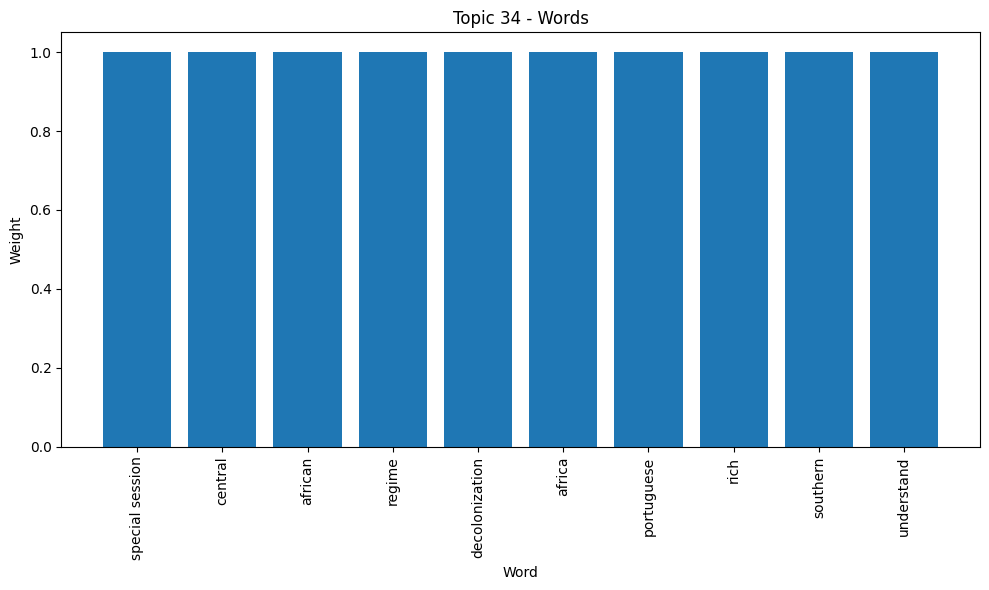

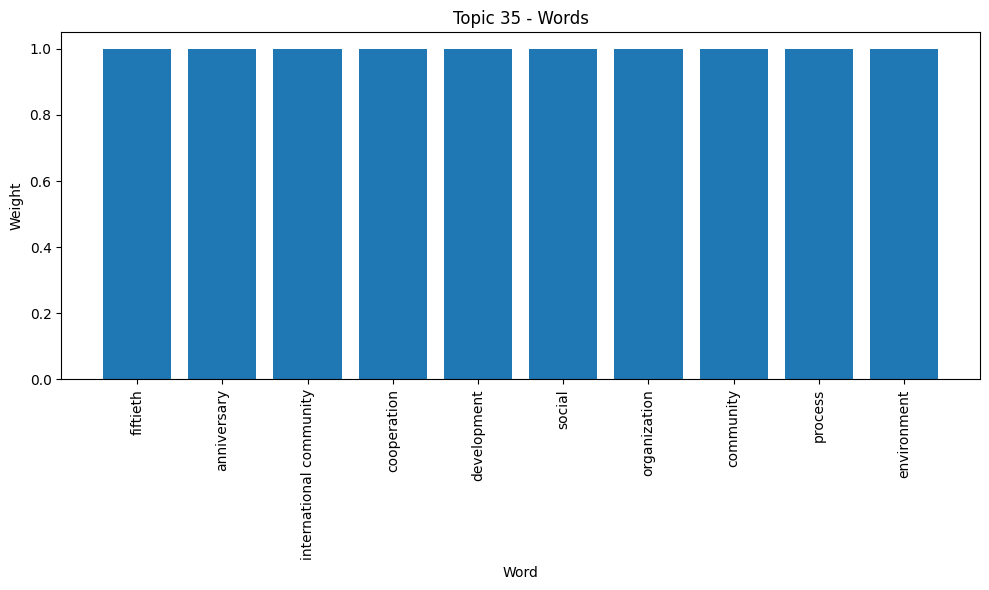

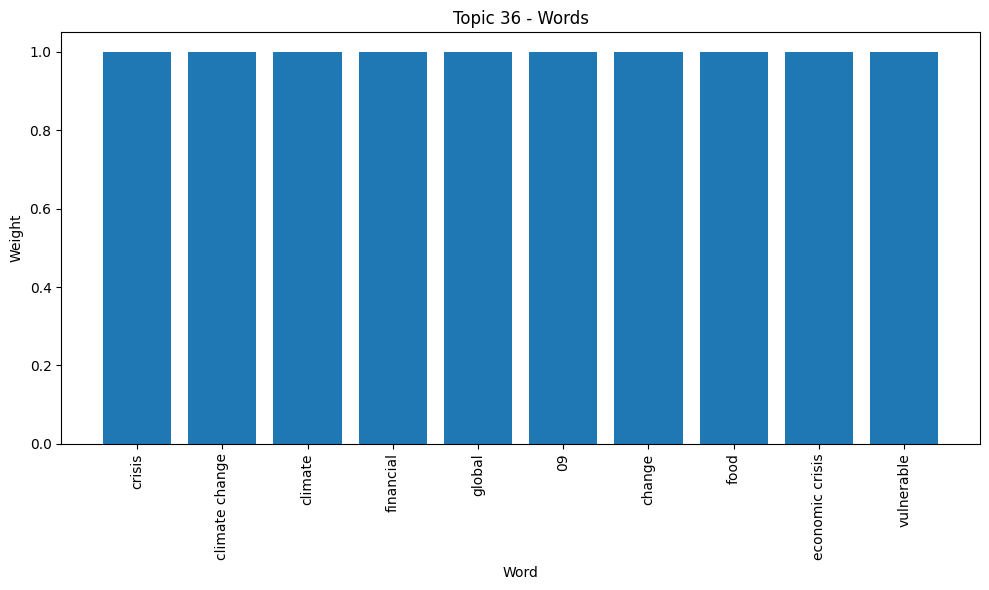

In [83]:
import matplotlib.pyplot as plt

# Assuming you have the df_topics DataFrame with 'Topic' and 'Words' columns

# Sort the DataFrame by topic index
df_topics_sorted = df_topics.sort_values('Topic')

# Create a bar plot for each topic
for index, row in df_topics_sorted.iterrows():
    topic = row['Topic']
    words = row['Words']
    
    # Extract words from the list of tuples
    words_list = [word for word, _ in words]
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(words_list)), [1] * len(words_list))
    plt.xlabel('Word')
    plt.ylabel('Weight')
    plt.title('Topic {} - Words'.format(topic))
    plt.xticks(range(len(words_list)), words_list, rotation=90)
    plt.tight_layout()
    plt.show()